In [1]:
import numpy as np 
from scipy import signal
import sys 
import os
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath("/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering"))
from Code.utilities import DAS
import scipy.ndimage
import scipy.signal
import matplotlib.patches as patches
from matplotlib.patches import Patch
from scipy.signal import correlate

In [2]:
        
def crossCorrOneBit(virtualSrcTrace, allOtherReceiversTraces, nLagSamples, version = 'C'):
    '''version = C or python where that determines which language is used for correlation calculation'''
    numberChannels = allOtherReceiversTraces.shape[0]
    xCorr = np.empty((numberChannels,1+2*nLagSamples),dtype=np.int32)
    
        #number of samples 
    nt = allOtherReceiversTraces.shape[1]
        
    sumWidth = nt-2*nLagSamples
	# do +- 1 bit thresholding
    vsOneBit = np.ones_like(virtualSrcTrace)
	# ****do threhsolding***
    recsOneBit = np.ones_like(allOtherReceiversTraces)
    print(vsOneBit)
    print(recsOneBit)
	# ****do thresholding
    for i in range(-1*nLagSamples,nLagSamples+1):
        startSample = i + nLagSamples
        endSample = startSample + sumWidth
        #do the actual integration 
        # source * rec
        tempArray = vsOneBit[startSample:endSample]*recsOneBit[:,nLagSamples:nLagSamples+sumWidth]
        xCorr[:,i+nLagSamples] = np.sum(tempArray,axis=1)
    return xCorr

In [3]:
def bpfilter(data, dt, bp_low, bp_high):
    '''
    Butterworth filter
    '''
    sos = signal.butter(6, [bp_low, bp_high], btype='bandpass', fs=1/dt, output='sos')
    return signal.sosfiltfilt(sos, data, axis=-1)

def DAS_preprocessing(data, dt, fl, fh):
    """this is important otherwise the plot doesn't look right 

    Args:
        data (_type_): _description_
        dt (_type_): _description_
        fl (_type_): _description_
        fh (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = signal.detrend(data, axis=1)
    data = data - np.median(data, axis=0)
    data = bpfilter(data, dt, fl, fh)
    print(dt)
    return data

In [4]:
t = np.linspace(0, 5, 100)
source = np.sin(t)
recievers = [np.cos(t) if i ==1 else np.sin(t) for i in range(2)]
recievers = np.stack(recievers, axis=1)
correlation = np.correlate(source, recievers[:,0])
one_bit_correlation = DAS.one_bit_cross_cor(source, recievers.T, 6)
print("correlation is", correlation)
print("one bit corss correlation is", one_bit_correlation)
correlation_signal = signal.correlate(source, recievers[:, 0])
print(correlation_signal.shape)


correlation is [52.65038234]
one bit corss correlation is [81.  7.]
(199,)


In [5]:

DAS_Stanford = np.load("../Data/september10data/20160910_00:00:54.npy")
DAS_Stanford = DAS_preprocessing(DAS_Stanford, .02, fl=0.2, fh = 24)

0.02


In [6]:
n_channels = 286
n_time_lags = 200
source_channel = 140

time_lags = np.linspace(0, n_time_lags,n_time_lags)
cross_cor_DAS = np.zeros((n_channels, n_time_lags))
#vectorize ? 
for i in range(n_time_lags): 
    cor = DAS.one_bit_cross_cor(DAS_Stanford[source_channel, :], DAS_Stanford[:n_channels,:], i)
    cross_cor_DAS[:, i] = cor / np.linalg.norm(cor, ord=1)


0.055474603726414044


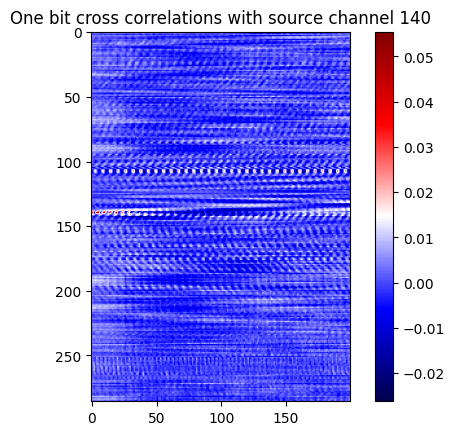

In [7]:
print(np.max(cross_cor_DAS))
plt.imshow(cross_cor_DAS , cmap="seismic")
plt.title(f'One bit cross correlations with source channel {source_channel}')
plt.colorbar()

## Try to implement a Semblence SNR 

In [8]:
DAS_Stanford.shape

(286, 15000)

In [9]:
def zero_time_lag_cross_cor(channel_a, channel_b):
    return np.sum(channel_a * channel_b)

def semblance(DAS_sample):
    n_channels = DAS_sample.shape[0]

    square_sum = np.sum(np.sum(DAS_sample, axis=0)**2, axis=0)
    sum_squares = np.sum(np.sum((DAS_sample**2), axis=0), axis=0)
    return square_sum/ (n_channels * sum_squares)

def SNR_sem(DAS_sample):
    s = semblance(DAS_sample)

    print(f'semblance is {s}')

    snr = s / (1 -s)
    return snr




In [10]:
# Works on older versions of scipy
def correlate_func(x, idx, cc_thresh = 0.9):
    correlation = correlate(x[idx,:], x[(idx+1),:], mode="full")
    lags = np.arange(-(x[idx,:].size - 1), x[(idx+1),:].size)
    lag_idx = np.argmax(correlation)
    lag = lags[lag_idx]
    if lag > 0:
        if np.corrcoef(x[idx,lag:], x[(idx+1),:-lag], rowvar=False)[0,1] > cc_thresh:
            x = np.concatenate(
                [np.concatenate([x[:(idx+1),:], np.zeros((x[:(idx+1),:].shape[0], lag))], axis=1),
                 np.concatenate([np.zeros((x[(idx+1):,:].shape[0], lag)), x[(idx+1):,:]], axis=1)],
                axis=0)
    if lag < 0:
        if np.corrcoef(x[idx,:-lag], x[(idx+1),lag:], rowvar=False)[0,1] > cc_thresh:
            x = np.concatenate(
                [np.concatenate([np.zeros((x[:(idx+1),:].shape[0], abs(lag))), x[:(idx+1),:]], axis=1),
                 np.concatenate([x[(idx+1):,:], np.zeros((x[(idx+1):,:].shape[0], abs(lag)))], axis=1)],
                axis=0)

    return(x)

# Looks at all previous channels in window and shifts relative to channel with highest xcorr
def correlate_func2(x, idx, cc_thresh = 0.9):
    correlation = correlate(x[:idx,:], x[(idx+1):(idx+2),:], mode="full", method="direct")
    idx_max_xcorr = np.argmax(np.amax(correlation, axis=1))

    lags = np.arange(-(x[idx_max_xcorr,:].size - 1), x[(idx+1),:].size)
    lag_idx = np.argmax(correlation[idx_max_xcorr,:])
    lag = lags[lag_idx]

    if lag > 0:
        if np.corrcoef(x[idx_max_xcorr,lag:], x[(idx+1),:-lag], rowvar=False)[0,1] > cc_thresh:
            # Need to check difference in zeros at start
            idx_max_xcorr_start = np.amin(np.where(x[idx_max_xcorr,:] != 0))
            idx_plus1_start = np.amin(np.where(x[(idx+1),:] != 0))
            lag = lag - (idx_plus1_start - idx_max_xcorr_start)
            if lag > 0:
                # Concatenate zeros to shift signal
                x = np.concatenate(
                    [np.concatenate([x[:(idx+1),:], np.zeros((x[:(idx+1),:].shape[0], lag))], axis=1),
                     np.concatenate([np.zeros((x[(idx+1):,:].shape[0], lag)), x[(idx+1):,:]], axis=1)],
                    axis=0)
    if lag < 0:
        if np.corrcoef(x[idx,:-lag], x[(idx+1),lag:], rowvar=False)[0,1] > cc_thresh:
            # Need to check difference in zeros at start
            idx_max_xcorr_start = np.amin(np.where(x[idx_max_xcorr,:] != 0))
            idx_plus1_start = np.amin(np.where(x[(idx+1),:] != 0))
            lag = lag + (idx_plus1_start - idx_max_xcorr_start)
            if lag < 0:
                # Concatenate zeros to shift signal
                x = np.concatenate(
                    [np.concatenate([np.zeros((x[:(idx+1),:].shape[0], abs(lag))), x[:(idx+1),:]], axis=1),
                     np.concatenate([x[(idx+1):,:], np.zeros((x[(idx+1):,:].shape[0], abs(lag)))], axis=1)],
                    axis=0)

    return(x)


# This is equal to first part of Eq 7 in https://doi.org/10.1111/1365-2478.13178
def marfurt_semblance(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    # Cross correlation and shift
    #this didn't change semblance
    '''
    for i in range(ntraces-1):
        region = correlate_func(region, i, cc_thresh = 0.7)
    '''
    

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    sembl = square_of_sums.sum() / sum_of_squares.sum()
    return sembl / ntraces

def moving_window(data, window, func):
    wrapped = lambda region: func(region.reshape(window))
    return scipy.ndimage.generic_filter(data, wrapped, window)

no_chan = 100
no_samp = 200

In [11]:
#Test semblance with Stanford das 
DAS_Stanford_raw = np.load("../Data/september10data/20160910_00:00:54.npy")
#print(f'singal to noise ratio of raw DAS is {SNR_sem(DAS_Stanford_raw)}')
proccessed_DAS = bpfilter(DAS_Stanford_raw, .02, 0.2, 24)
#print(f'singal to noise ratio of processesd DAS is  {SNR_sem(proccessed_DAS)}')

S_raw_ex = moving_window(DAS_Stanford_raw, (no_chan, no_samp), marfurt_semblance)

In [12]:
plt.imshow(S_raw_ex, aspect='auto')

NameError: name 'S_raw_ex' is not defined

In [ ]:
print(DAS_Stanford_raw.shape)
test_semblance = marfurt_semblance(DAS_Stanford_raw[175:200, :])
print(f'paper semblance is {test_semblance}')
local_snr = test_semblance / (1-test_semblance)
print(f'local snr is {local_snr}')
test_semblance = marfurt_semblance(proccessed_DAS[175:200, :])
print(f'paper semblance after proccessing is {test_semblance}')
local_snr = test_semblance / (1-test_semblance)
print(f'local snr after proccessing {local_snr}')

(286, 15000)
paper semblance is 0.019661023425985115
local snr is 0.020055331773805814
paper semblance after proccessing is 0.548725079102808
local snr after proccessing 1.2159441034566527


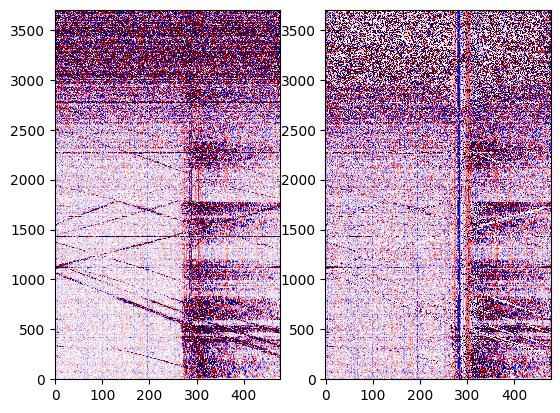

In [ ]:
# Test semblance with inveres 
inverse_313 = np.load("../Data/inference/cwt_2023p313442.npy_invers.npy")
muted_313 = np.load("../Data/inference/cwt_2023p313442.npy_muted.npy")

fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(inverse_313 / inverse_313.std(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto',vmin=-1, vmax=1)
ax2.imshow(muted_313 / muted_313.std(), origin='lower', interpolation='nearest', cmap='seismic', aspect='auto',vmin=-1, vmax=1)



In [ ]:
start =750
end = 1000
sem_normal = marfurt_semblance(inverse_313)
sem_muted = marfurt_semblance(muted_313)
print(f'semblance from me {semblance(muted_313)}')

print(f'semblance of normal inverse from channels {start} to {end}: {sem_normal}')
print(f'semblance of muted inverse from channels {start} to {end}: {sem_muted}')

print(f'snr of normal is {sem_normal / (1-sem_normal)}')
print(f'snr of muted is {sem_muted / (1-sem_muted)}')


semblance from me 0.013298491557884064
semblance of normal inverse from channels 750 to 1000: 0.01139314025162177
semblance of muted inverse from channels 750 to 1000: 0.013298491557884064
snr of normal is 0.011524439810706522
snr of muted is 0.013477724969611932


In [ ]:
mask = np.zeros(inverse_313.shape)
mask[start:end, : ] =1
masked = muted_313 * mask
print(f'semblance with mask {semblance(masked)}')


semblance with mask 0.005324790082950506
